# DCGAN on celeba

In [1]:
%matplotlib inline

import os
import cv2
import pickle
import hashlib
import zipfile
import glob
from tqdm import tqdm
from urllib.request import urlretrieve
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

## Get celeba data

In [2]:
class Dataset():
    """
    Dataset
    """
    def __init__(self, data_files, width=64, height=64):
        self.width = width
        self.height = height
        self.image_channels = 3
        self.data_files = data_files
        self.shape = len(data_files), self.width, self.height, self.image_channels
        
    def get_image(self, filename):
        img = cv2.imread(filename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, self.shape[1:3])
        img = img.astype(float)
        img /= 255.0
        img = 2*img - 1.0 # value range -1 to 1
        return img

    def gen_batches(self, batch_size):
        batch = np.zeros(shape=(batch_size, self.height, self.width, self.image_channels), dtype=np.float)
        image_index = 0
        
        while True:
            for batch_index in range(batch_size):
                batch[batch_index, :] = self.get_image(self.data_files[image_index])
                image_index = (image_index + 1) % self.shape[0]
            
            yield batch

In [3]:
class DLProgress(tqdm):
    """
    Handle Progress Bar while Downloading
    """
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        """
        A hook function that will be called once on establishment of the network connection and
        once after each block read thereafter.
        :param block_num: A count of blocks transferred so far
        :param block_size: Block size in bytes
        :param total_size: The total size of the file. This may be -1 on older FTP servers which do not return
                            a file size in response to a retrieval request.
        """
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

In [4]:
# Test existence of data
url = 'https://s3-us-west-1.amazonaws.com/udacity-dlnfd/datasets/celeba.zip'
hash_code = '00d2c5bc6d35e252742224ab0c1e8fcb'
data_path = '../data'
zip_file = 'celeba.zip'
zip_path = os.path.join(data_path, zip_file)
extract_path = os.path.join(data_path, 'img_align_celeba')

exists = { 
    'zip': os.path.exists(zip_path),
    'hash_ok': False,
    'img_folder': os.path.exists(extract_path), 
    'all_imgs': len(glob.glob(extract_path+'/*.jpg')) == 202599
}

if os.path.exists(zip_path):
    exists['hash_ok'] = hashlib.md5(open(zip_path, 'rb').read()).hexdigest() == hash_code

print(exists)

if not exists['all_imgs']:
    # Download zip file, if it does not exist or corrupted
    if not exists['zip'] or not exists['hash_ok']:
        # delete file, if it exists
        os.remove(zip_path)
        with DLProgress(unit='B', unit_scale=True, miniters=1, desc='Downloading {}'.format(zip_file)) as pbar:
            urlretrieve(url, save_path, pbar.hook)
    # Zip file exists
    # Create folder to unzip, if it does not exist
    if not exists['img_folder']:
        os.makedirs(extract_path)
    # Unzip file
    print('Extracting {}...'.format(zip_file))
    with zipfile.ZipFile(zip_path) as zf:
        zf.extractall(extract_path)

{'img_folder': True, 'all_imgs': True, 'hash_ok': False, 'zip': False}


In [5]:
from distutils.version import LooseVersion
import warnings

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /device:GPU:0


In [6]:
def display_images(image_batch, nrows):
    ncols = np.int(np.ceil(image_batch.shape[0]/nrows))
    assert ncols*nrows == image_batch.shape[0], \
        'Cannot divide number of images {} by number of rows {}.'.format(image_batch.shape[0], nrows)
    imsize = 1.5
    
    f, axarr = plt.subplots(nrows, ncols, figsize=(nrows*imsize, ncols*imsize), sharex=True, sharey=True)
    
    for i in range(image_batch.shape[0]):
        axarr[i//ncols, i%ncols].imshow((image_batch[i]+1)/2)        
        axarr[i//ncols, i%ncols].tick_params(which='both', 
                    bottom='off', top='off', left='off', right='off', 
                    labelbottom='off', labeltop='off', labelleft='off', labelright='off')
        axarr[i//ncols, i%ncols].axis('off')

    plt.subplots_adjust(wspace=0, hspace=0)
    


(16, 64, 64, 3)


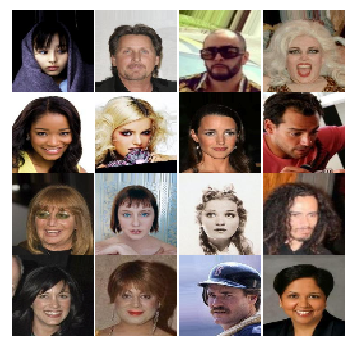

In [7]:
celeba = Dataset(data_files=glob.glob(extract_path+'/*.jpg'), width=64, height=64)
gen_batches = celeba.gen_batches(16)
batch = next(gen_batches)
print(batch.shape)

display_images(batch, 4)

In [ ]:
!mkdir chck

In [8]:
class DCGAN():
    
    def __init__(self, alpha=0.2, beta1=0.2, smooth=0.9, build=True):
        # sizes
        self.io_shape = (32, 32, 3)
        self.z_shape = (100, )
        self.alpha = alpha
        self.beta1 = beta1
        self.smooth = smooth
        
        # graph config
        self.gc = dict()
        
        if build:
            self.build()
            # Save names
            self.set_gc_names()
            
    def placeholders(self):
        self.input = tf.placeholder(tf.float32, shape=[None, *self.io_shape], name='input')
        self.z = tf.placeholder(tf.float32, shape=[None, *self.z_shape], name='z')
        self.lr = tf.placeholder(tf.float32, name='learning_rate')
        
    def generator(self, i, training=True, reuse=False):
        with tf.variable_scope('generator', reuse=reuse):
            layer = tf.contrib.layers.fully_connected(i, 4*4*512, activation_fn=None)
            #layer = tf.maximum(layer, layer * self.alpha)
            # 512
            layer = tf.reshape(layer, (-1, 4, 4, 512))
            layer = tf.layers.batch_normalization(layer, training=training)
            layer = tf.maximum(layer, layer * self.alpha)
            # 4x4x512
            layer = tf.layers.conv2d_transpose(layer, 256, 3, strides=2, padding='same')
            layer = tf.layers.batch_normalization(layer, training=training)
            layer = tf.maximum(layer, layer * self.alpha)
            # 8x8x256
            layer = tf.layers.conv2d_transpose(layer, 128, 5, strides=2, padding='same')
            layer = tf.layers.batch_normalization(layer, training=training)
            layer = tf.maximum(layer, layer * self.alpha)
            # 16x16x128
            layer = tf.layers.conv2d_transpose(layer, 64, 3, strides=2, padding='same')
            layer = tf.layers.batch_normalization(layer, training=training)
            layer = tf.maximum(layer, layer * self.alpha)
            # 32x32x64
            layer = tf.layers.conv2d_transpose(layer, 3, 5, strides=1, padding='same')
            
            out = tf.tanh(layer)
            
            return out
        
    def generator__(self, i, training=True, reuse=False):
        with tf.variable_scope('generator', reuse=reuse):
            layer = tf.contrib.layers.fully_connected(i, 4*4*512, activation_fn=None)
            #layer = tf.maximum(layer, layer * self.alpha)
            # 512
            layer = tf.reshape(layer, (-1, 4, 4, 512))
            layer = tf.layers.batch_normalization(layer, training=training)
            layer = tf.maximum(layer, layer * self.alpha)
            # 4x4x512
            layer = tf.contrib.layers.conv2d_transpose(layer, num_outputs=256, kernel_size=3, stride=2, padding='SAME')
            layer = tf.layers.batch_normalization(layer, training=training)
            layer = tf.maximum(layer, layer * self.alpha)
            # 8x8x256
            layer = tf.contrib.layers.conv2d_transpose(layer, num_outputs=128, kernel_size=5, stride=2, padding='SAME')
            layer = tf.layers.batch_normalization(layer, training=training)
            layer = tf.maximum(layer, layer * self.alpha)
            # 16x16x128
            layer = tf.contrib.layers.conv2d_transpose(layer, num_outputs=64, kernel_size=3, stride=2, padding='SAME')
            layer = tf.layers.batch_normalization(layer, training=training)
            layer = tf.maximum(layer, layer * self.alpha)
            # 32x32x64
            layer = tf.contrib.layers.conv2d_transpose(layer, num_outputs=3, kernel_size=5, stride=1, padding='SAME')
            
            out = tf.tanh(layer)
            
            return out
        
    def generator_(self, z, training=True, reuse=False, is_train=True):
        #def generator(z, out_channel_dim, is_train=True, alpha=0.1):
        alpha = self.alpha
        out_channel_dim = 3
        with tf.variable_scope('generator', reuse=reuse):
            # First fully connected layer
            x1 = tf.layers.dense(z, 4*4*512)
            # Reshape it to start the convolutional stack
            x1 = tf.reshape(x1, (-1, 4, 4, 512))
            x1 = tf.layers.batch_normalization(x1, training=is_train)
            x1 = tf.maximum(alpha * x1, x1)
            # 3x3x512 now
        
            x2 = tf.layers.conv2d_transpose(x1, 256, 3, strides=2, padding='same')
            x2 = tf.layers.batch_normalization(x2, training=is_train)
            x2 = tf.maximum(alpha * x2, x2)
            # 7x7x256 now
        
            x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
            x3 = tf.layers.batch_normalization(x3, training=is_train)
            x3 = tf.maximum(alpha * x3, x3)
            # 14x14x128 now
        
            x4 = tf.layers.conv2d_transpose(x3, 64, 3, strides=2, padding='same')
            x4 = tf.layers.batch_normalization(x4, training=is_train)
            x4 = tf.maximum(alpha * x4, x4)
            # 28x28x64 now
        
            # Output layer
            logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding='same')
            # 28x28xout_channel_dim now
        
            out = tf.tanh(logits)
        
        return out            

    def discriminator(self, X, training=True, reuse=False):
        with tf.variable_scope('discriminator', reuse=reuse):            
            layer = tf.contrib.layers.conv2d(X, num_outputs=64, kernel_size=3, stride=2, padding='SAME')
            layer = tf.maximum(layer, layer * self.alpha)
            # 16x16x64            
            layer = tf.contrib.layers.conv2d(X, num_outputs=128, kernel_size=3, stride=2, padding='SAME')
            layer = tf.layers.batch_normalization(layer, training=training)
            layer = tf.maximum(layer, layer * self.alpha)
            # 8x8x128           
            layer = tf.contrib.layers.conv2d(X, num_outputs=256, kernel_size=5, stride=2, padding='SAME')
            layer = tf.layers.batch_normalization(layer, training=training)
            layer = tf.maximum(layer, layer * self.alpha)
            # 4x4x256
            layer = tf.contrib.layers.flatten(layer)
            # 512
            #layer = tf.contrib.layers.fully_connected(layer, 64, activation_fn=None)
            #layer = tf.layers.batch_normalization(layer, training=training)
            #layer = tf.maximum(self.alpha*layer, layer)
            # 64            
            logits = tf.contrib.layers.fully_connected(layer, 1, activation_fn=None)
            prob = tf.sigmoid(logits)
            
            return logits, prob
        
    def discriminator__(self, X, training=True, reuse=False):
        alpha = self.alpha
        with tf.variable_scope('discriminator', reuse=reuse):
            # Input layer is 32x32xC
            x1 = tf.layers.conv2d(X, 64, 5, strides=2, padding='same')
            relu1 = tf.maximum(alpha * x1, x1)
            # 14x14x64
        
            x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
            bn2 = tf.layers.batch_normalization(x2, training=True)
            relu2 = tf.maximum(alpha * bn2, bn2)
            # 7x7x128
        
            x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
            bn3 = tf.layers.batch_normalization(x3, training=True)
            relu3 = tf.maximum(alpha * bn3, bn3)
            # 4x4x256

            # Flatten it
            flat = tf.reshape(relu3, (-1, 4*4*256))
            logits = tf.layers.dense(flat, 1)
            out = tf.sigmoid(logits)        

        return logits, out        
            
    def build(self):
        self.placeholders()
        
        self.sample_train = self.generator(self.z)
        self.sample = self.generator(self.z, reuse=True, training=False)
        #print(self.sample.get_shape().as_list())
        #print(self.input.get_shape().as_list())        
        fake_logits, fake_prob = self.discriminator(self.sample_train)
        real_logits, real_prob = self.discriminator(self.input, reuse=True)       
        
        # Loss functions
        dloss_fake = tf.nn.sigmoid_cross_entropy_with_logits(
            logits=fake_logits, labels=tf.zeros_like(fake_logits))
        dloss_real = tf.nn.sigmoid_cross_entropy_with_logits(
            logits=real_logits, labels=tf.ones_like(real_logits)*self.smooth)
        self.dloss = tf.reduce_mean(dloss_fake + dloss_real)
        
        self.gloss = tf.reduce_mean(
                        tf.nn.sigmoid_cross_entropy_with_logits(
                            logits=fake_logits, labels=tf.ones_like(fake_logits)))
        
        # Trainable parameters
        gvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='generator')
        dvars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope='discriminator')
        
        with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
            # Optimizers
            self.train_discriminator = tf.train.AdamOptimizer(self.lr, beta1=self.beta1).minimize(self.dloss, var_list=dvars)
            self.train_generator = tf.train.AdamOptimizer(self.lr, beta1=self.beta1).minimize(self.gloss, var_list=gvars)
    
    def set_gc_names(self):
        for k, v in self.__dict__.items():
            if isinstance(v, tf.Tensor) or isinstance(v, tf.Operation):
                self.gc[k] = self.__dict__[k].name
            if isinstance(v, list):
                if all(map(lambda x: isinstance(x, tf.Tensor) or isinstance(x, tf.Operation), v)):
                    self.gc[k] = [_.name for _ in v]
        
    def print_gc_names(self):
        for k, n in self.gc.items():
            print(k, n)
            
    def get_from_graph(self, name, graph):
        try:
            return graph.get_tensor_by_name(name)
        except:
            try:
                return graph.get_operation_by_name(name)
            except:
                raise 
           
    def init_from_graph(self, graph, gc):
        self.gc = gc
        for k, n in self.gc.items():
            if isinstance(n, list):
                self.__dict__[k] = [self.get_from_graph(_, graph) for _ in n]
            else:
                self.__dict__[k] = self.get_from_graph(n, graph)    

Epoch  1:   3%|▎         | 6400/202599 [00:27<13:35, 240.72 examples/s, Dloss=6.1266, Gloss=0.3078]   

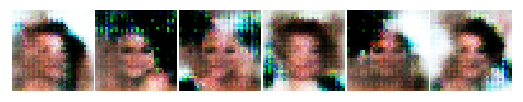

Epoch  1:   6%|▋         | 12800/202599 [01:56<45:12, 69.96 examples/s, Dloss=3.8855, Gloss=13.7168]

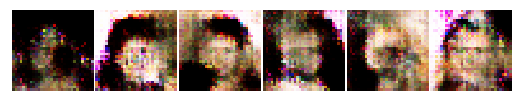

Epoch  1:   9%|▉         | 19200/202599 [03:24<43:44, 69.88 examples/s, Dloss=2.7993, Gloss=4.6920] 

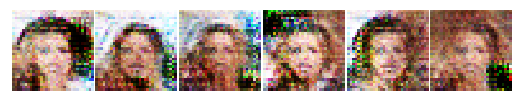

Epoch  1:  13%|█▎        | 25600/202599 [04:55<41:33, 70.97 examples/s, Dloss=2.6056, Gloss=4.9048] 

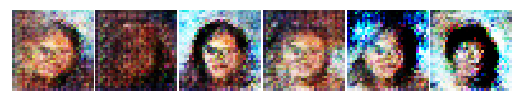

Epoch  1:  16%|█▌        | 32000/202599 [06:26<38:26, 73.98 examples/s, Dloss=2.0071, Gloss=4.1969]

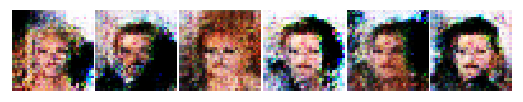

Epoch  1:  19%|█▉        | 38400/202599 [07:57<39:28, 69.32 examples/s, Dloss=2.4703, Gloss=3.6764]

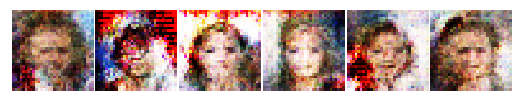

Epoch  1:  22%|██▏       | 44800/202599 [09:27<37:34, 69.99 examples/s, Dloss=2.4711, Gloss=0.9987]

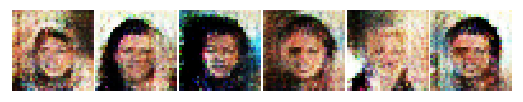

Epoch  1:  25%|██▌       | 51200/202599 [10:58<36:57, 68.28 examples/s, Dloss=2.0413, Gloss=2.5117]

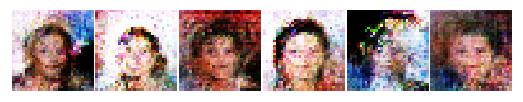

Epoch  1:  28%|██▊       | 57600/202599 [12:30<34:23, 70.27 examples/s, Dloss=2.0396, Gloss=2.4005]

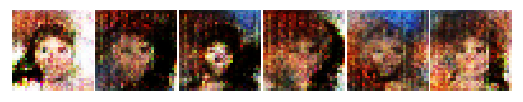

Epoch  1:  32%|███▏      | 64000/202599 [14:01<31:39, 72.95 examples/s, Dloss=1.7236, Gloss=2.2685]

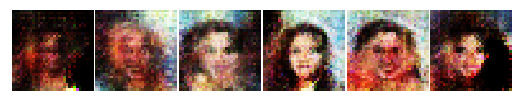

Epoch  1:  35%|███▍      | 70400/202599 [15:32<31:28, 70.00 examples/s, Dloss=2.3748, Gloss=0.7141]

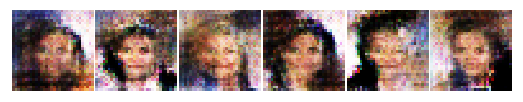

Epoch  1:  38%|███▊      | 76800/202599 [17:03<29:37, 70.76 examples/s, Dloss=1.6098, Gloss=0.9901]

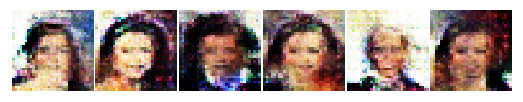

Epoch  1:  41%|████      | 83200/202599 [18:33<27:18, 72.88 examples/s, Dloss=1.8205, Gloss=0.6324]

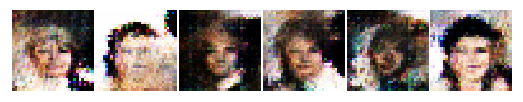

Epoch  1:  44%|████▍     | 89600/202599 [20:05<27:14, 69.13 examples/s, Dloss=1.3948, Gloss=0.9943]

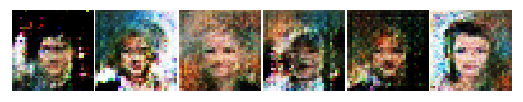

Epoch  1:  47%|████▋     | 96000/202599 [21:40<25:36, 69.40 examples/s, Dloss=1.5214, Gloss=1.3001]  

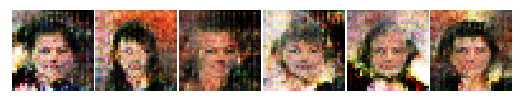

Epoch  1:  51%|█████     | 102400/202599 [23:11<23:31, 70.98 examples/s, Dloss=1.4147, Gloss=1.3129]

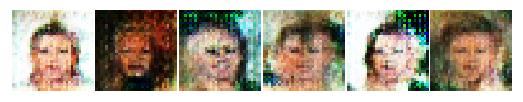

Epoch  1:  54%|█████▎    | 108800/202599 [24:41<21:50, 71.59 examples/s, Dloss=1.3935, Gloss=0.9272]

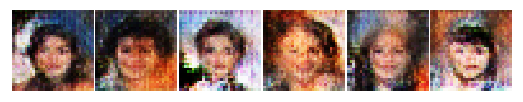

Epoch  1:  57%|█████▋    | 115200/202599 [26:12<20:57, 69.50 examples/s, Dloss=1.4515, Gloss=1.2661]

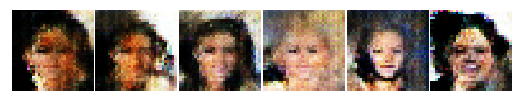

Epoch  1:  60%|██████    | 121600/202599 [27:43<18:47, 71.83 examples/s, Dloss=1.5380, Gloss=1.6613]

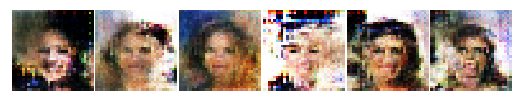

Epoch  1:  63%|██████▎   | 128000/202599 [29:14<18:10, 68.41 examples/s, Dloss=1.3817, Gloss=1.0838]

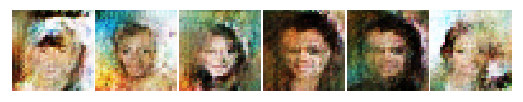

Epoch  1:  66%|██████▋   | 134400/202599 [30:46<15:46, 72.04 examples/s, Dloss=1.4165, Gloss=0.8138]

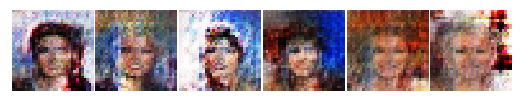

Epoch  1:  69%|██████▉   | 140800/202599 [32:16<14:25, 71.40 examples/s, Dloss=1.4313, Gloss=1.0548]

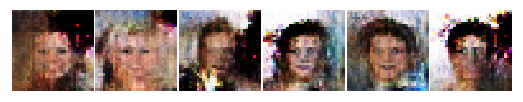

Epoch  1:  73%|███████▎  | 147200/202599 [33:47<13:17, 69.45 examples/s, Dloss=1.4365, Gloss=0.8749]

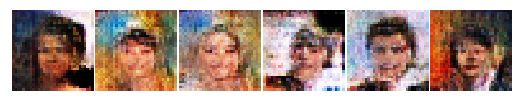

Epoch  1:  76%|███████▌  | 153600/202599 [35:19<12:27, 65.52 examples/s, Dloss=1.4463, Gloss=0.7099]

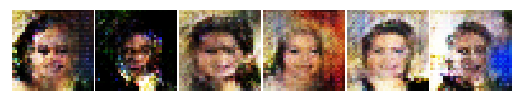

Epoch  1:  79%|███████▉  | 160000/202599 [36:53<09:57, 71.27 examples/s, Dloss=1.4173, Gloss=0.8921]

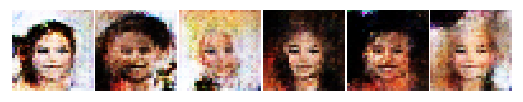

Epoch  1:  82%|████████▏ | 166400/202599 [38:24<08:17, 72.78 examples/s, Dloss=1.3812, Gloss=0.8966]

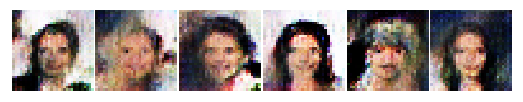

Epoch  1:  85%|████████▌ | 172800/202599 [39:55<06:58, 71.25 examples/s, Dloss=1.3914, Gloss=0.7860]

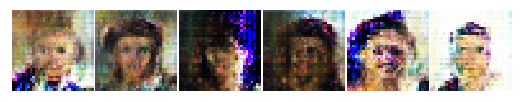

Epoch  1:  88%|████████▊ | 179200/202599 [41:27<05:34, 69.96 examples/s, Dloss=1.4017, Gloss=0.6623]

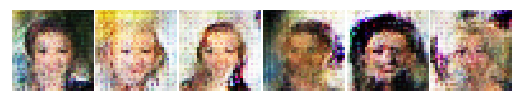

Epoch  1:  92%|█████████▏| 185600/202599 [42:57<04:10, 67.90 examples/s, Dloss=1.3986, Gloss=0.9270]

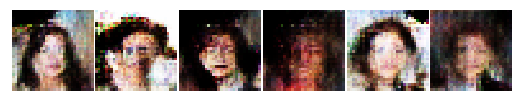

Epoch  1:  95%|█████████▍| 192000/202599 [44:32<02:30, 70.26 examples/s, Dloss=1.3952, Gloss=0.7106]

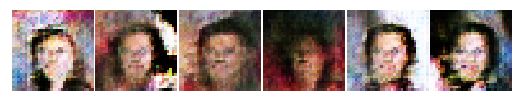

Epoch  1:  98%|█████████▊| 198400/202599 [46:03<00:59, 70.67 examples/s, Dloss=1.4179, Gloss=0.8031]

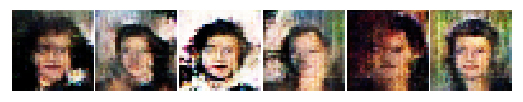

Epoch  1: 100%|█████████▉| 202592/202599 [47:03<00:00, 70.86 examples/s, Dloss=1.3765, Gloss=0.9524]


In [11]:
# Train the model and save it
celeba = Dataset(data_files=glob.glob(extract_path+'/*.jpg'), width=32, height=32)
batch_size = 32
nepochs = 1
display_every = 200
restore_model = False # False, True
gen_batches = celeba.gen_batches(batch_size)

tf.reset_default_graph()
if restore_model:    
    model = DCGAN(build=False)    
else:
    model = DCGAN()
    with open('chck/dcgan_celeba.pickle', 'wb') as f:
        pickle.dump(model.gc, f)

with tf.Session() as sess:
    if restore_model:
        saver = tf.train.import_meta_graph('chck/dcgan_celeba.meta')
        saver.restore(sess, "chck/dcgan_celeba")
        with open('chck/dcgan_celeba.pickle', 'rb') as f:
            gc = pickle.load(f) 
        model.init_from_graph(sess.graph, gc)
    else:
        sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()

    num_examples = celeba.shape[0]//1
    with tqdm(desc='Epoch', total=num_examples*nepochs, unit=' examples') as pbar:
        dloss, gloss = 0.0, 0.0
        dlosses, glosses = [], []
        samples = []
        for epoch in range(nepochs):
            for batch_idx in range(int(num_examples//batch_size)):
                # Image batch
                batch = next(gen_batches)
                # Noise batch
                noise_batch = np.random.uniform(-1.0, 1.0, size=(batch_size, *model.z_shape))
                # Run optimizers
                _, dloss = sess.run([model.train_discriminator, model.dloss], 
                                feed_dict={model.input: batch, model.z: noise_batch, model.lr: 0.002})
                _, gloss = sess.run([model.train_generator, model.gloss], 
                                feed_dict={model.input: batch, model.z: noise_batch, model.lr: 0.002})
                
                pbar.set_description('Epoch {:2}'.format(epoch+1))
                pbar.update(batch_size)
                pbar.set_postfix(Dloss='{:.4f}'.format(dloss), 
                                Gloss='{:.4f}'.format(gloss))
                
                if batch_idx % display_every == (display_every - 1):
                    noise_batch = np.random.uniform(-1.0, 1.0, size=(6, *model.z_shape))
                    s = sess.run(model.sample, feed_dict={model.z: noise_batch})
                    s = np.array(s)
                    s = s[np.newaxis,:]
                    view_samples(s, imshape=(32, 32, 3))
                    plt.show()                    
        
            # Save discriminator and generator losses
            dlosses.append(dloss)
            glosses.append(gloss)
            
            # Generate samples
            noise_batch = np.random.uniform(-1.0, 1.0, size=(batch_size, *model.z_shape))
            s = sess.run(model.sample, feed_dict={model.z: noise_batch})
            samples.append(s)          

    save_path = saver.save(sess, "chck/dcgan_celeba")

with open('chck/dcgan_celeba_samples.pickle', 'wb') as f:
    pickle.dump(np.array(samples), f)    


(1, 6, 32, 32, 3)


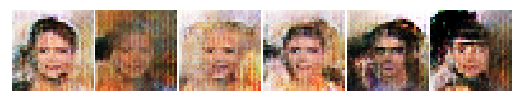

In [10]:
# Plot sample evolution in time
with open('chck/dcgan_celeba_samples.pickle', 'rb') as f:
    samples = pickle.load(f)

def select_samples(samples, T, N):
    assert T <= samples.shape[0], 'T ({}) must be <= {}'.format(T, samples.shape[0])
    assert N <= samples.shape[1], 'N ({}) must be <= {}'.format(N, samples.shape[1])
    
    indices = np.arange(samples.shape[0]-1, -1, -samples.shape[0]/T)
    indices = indices.astype(np.int32)
    indices = list(reversed(indices))
    
    return samples[indices, 0:N,:]
    
def view_samples(samples, imshape=(32,32,3)):
    nrows = samples.shape[0]
    ncols = samples.shape[1]
    
    fig, axes = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(1.5*ncols,1.5*nrows))
    for ir in range(nrows):
        axrow = axes[ir] if nrows>1 else axes
        for ic in range(ncols):
            img = np.reshape((samples[ir, ic, :]+1)/2.0, imshape)
            axrow[ic].imshow(img, aspect='equal')
            axrow[ic].xaxis.set_visible(False)
            axrow[ic].yaxis.set_visible(False)
            axrow[ic].tick_params(which='both', 
                    bottom='off', top='off', left='off', right='off', 
                    labelbottom='off', labeltop='off', labelleft='off', labelright='off')
            axrow[ic].axis('off')
    
    plt.subplots_adjust(wspace=0, hspace=0)


samples = select_samples(samples, T=1, N=6)
print(samples.shape)
view_samples(samples)

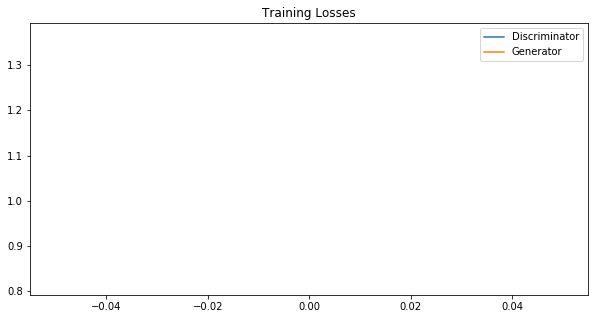

In [12]:
# Plot losses
fig, ax = plt.subplots(figsize=(10,5))
plt.plot(dlosses, label='Discriminator')
plt.plot(glosses, label='Generator')
plt.title("Training Losses")
plt.legend()